In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
import numba
from itertools import combinations
from collections import Counter

import community as community_louvain 
import pickle
import community
import random
import json
import seaborn as sns
import numpy as np

In [5]:
# recipes_df = pd.read_csv("data/RAW_recipes.csv")

In [6]:
# # Extract relevant data
# recipes_df['ingredients'] = recipes_df['ingredients'].apply(eval)  # Convert string to list

In [7]:
# # Extract unique ingredients and assign them indices
# all_ingredients = sorted(set(ing for lst in recipes_df['ingredients'] for ing in lst))
# ingredient_to_idx = {ing: idx for idx, ing in enumerate(all_ingredients)}

In [8]:
# # Convert recipes to binary ingredient vectors (Sparse)
# num_recipes = len(recipes_df)
# num_ingredients = len(all_ingredients)
# device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# recipe_matrix = torch.zeros((num_recipes, num_ingredients), dtype=torch.float16, device=device)
# for i, row in recipes_df.iterrows():
#     indices = [ingredient_to_idx[ing] for ing in row['ingredients']]
#     recipe_matrix[i, indices] = 1

In [10]:
# # Function to compute Jaccard similarity and store weighted edges
# def compute_weighted_edges_in_chunks(recipe_matrix, batch_size=1000, threshold=0.5):
#     edges = []
#     num_recipes = recipe_matrix.shape[0]

#     for start in range(0, num_recipes, batch_size):
#         end = min(start + batch_size, num_recipes)
#         chunk = recipe_matrix[start:end]  # Process batch

#         # Compute Jaccard similarity for this batch
#         intersection = torch.matmul(chunk, recipe_matrix.T)  # [batch_size, num_recipes]
#         row_sums = chunk.sum(dim=1, keepdim=True)  # [batch_size, 1]
#         col_sums = recipe_matrix.sum(dim=1, keepdim=True).T  # [1, num_recipes]
#         union = row_sums + col_sums - intersection

#         similarity = intersection / (union + 1e-6)  # Avoid division by zero
#         similarity.fill_diagonal_(0)  # Remove self-similarity

#         # Extract edges where similarity > threshold, and store weights
#         batch_edges = (similarity > threshold).nonzero(as_tuple=False).cpu().tolist()
#         weighted_edges = [(start + i, j, similarity[i, j].item()) for i, j in batch_edges]
#         edges.extend(weighted_edges)

#         del chunk, intersection, row_sums, col_sums, union, similarity
#         torch.cuda.empty_cache()  # Free GPU memory

#     return edges

In [11]:
# # Compute weighted edges efficiently
# weighted_edges = compute_weighted_edges_in_chunks(recipe_matrix, batch_size=1000, threshold=0.5)

In [12]:
# G = nx.Graph()
# G.add_nodes_from(recipes_df['name'])
# G.add_weighted_edges_from([(recipes_df['name'][i], recipes_df['name'][j], w) for i, j, w in weighted_edges])

In [13]:
def load_json_to_networkx(json_path):
    """
    Loads a JSON graph (exported for Flourish/VOSviewer) into NetworkX.

    Parameters:
    - json_path: Path to the JSON file.

    Returns:
    - G: NetworkX graph with nodes and edges.
    """
    # Load JSON file
    with open(json_path, "r") as f:
        data = json.load(f)

    # Create empty graph
    G = nx.Graph()

    # Add nodes with attributes
    for node in data["nodes"]:
        G.add_node(node["id"], label=node["label"], community=node.get("group", 0), size=node.get("size", 1))

    # Add edges with weights
    for link in data["links"]:
        G.add_edge(link["source"], link["target"], weight=link["weight"])

    print(f"Graph loaded from {json_path}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G


In [14]:
G = load_json_to_networkx("recipe-recipe-graph/recipe_similarity_network.json")

Graph loaded from recipe-recipe-graph/recipe_similarity_network.json: 230186 nodes, 1309459 edges


In [10]:
# # Load the graph from .pkl
# with open("recipe-recipe.pkl", "rb") as f:
#     G = pickle.load(f)

In [15]:
# Compute degree distribution
degrees = [deg for _, deg in G.degree()]
degree_counts = Counter(degrees)

In [16]:
# Convert to sorted lists
degree, count = zip(*sorted(degree_counts.items()))


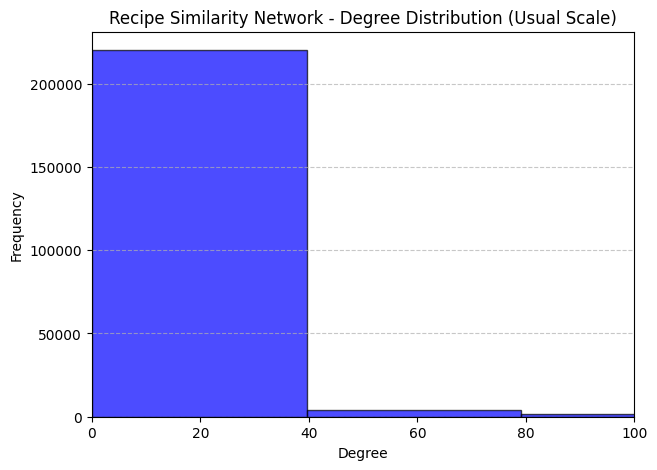

In [13]:
# Plot Histogram (Usual Scale) with limited x-axis range
plt.figure(figsize=(7, 5))
plt.hist(degrees, bins=50, color='b', edgecolor='black', alpha=0.7)
plt.xlim(0, min(100, max(degrees)))  # Limit x-axis to 100 or max degree if smaller
plt.title("Recipe Similarity Network - Degree Distribution (Usual Scale)")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

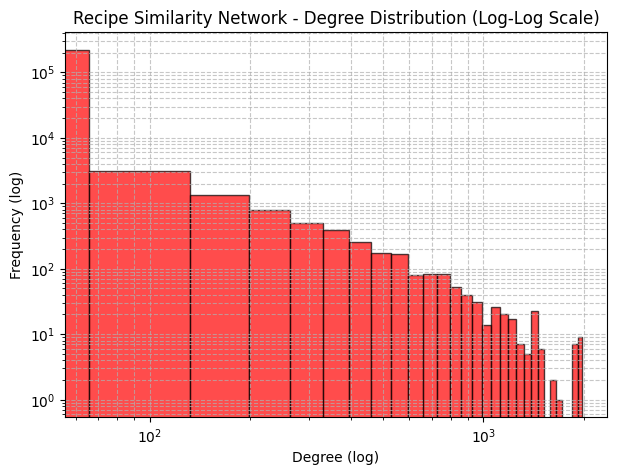

In [14]:
# Plot Histogram (Log-Log Scale)
plt.figure(figsize=(7, 5))
plt.hist(degrees, bins=30, color='r', edgecolor='black', alpha=0.7, log=True)
plt.yscale("log")
plt.xscale("log")
plt.title("Recipe Similarity Network - Degree Distribution (Log-Log Scale)")
plt.xlabel("Degree (log)")
plt.ylabel("Frequency (log)")
plt.grid(which="both", linestyle="--", alpha=0.7)
plt.show()

In [15]:

# Report graph statistics
print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")

Number of Nodes: 230186
Number of Edges: 1309459


In [4]:
def networkx_louvain(G):
    if nx.is_directed(G):
        G = G.to_undirected()  # Convert directed graph to undirected

    # Run Louvain algorithm
    partition = community.best_partition(G)  # Returns {node: community_id}

    # Compute modularity correctly
    modularity = community.modularity(partition, G, weight="weight")

    # Convert partition dict to a list of sets (for easy handling)
    communities = {}
    for node, comm_id in partition.items():
        communities.setdefault(comm_id, set()).add(node)

    # Convert dictionary to list
    community_list = list(communities.values())

    return community_list, modularity, partition

In [5]:
communities, modularity, partition = networkx_louvain(G)
print(f"Number of communities: {len(communities)}")
print(f"Modularity: {modularity:.4f}")


KeyboardInterrupt: 

In [32]:
def analyze_communities(G, communities):
    print("\nCommunity Statistics:")
    
    # Convert to partition format if needed
    if isinstance(communities, list):
        partition = {node: i for i, comm in enumerate(communities) for node in comm}
        communities_dict = {i: comm for i, comm in enumerate(communities)}
        num_communities = len(communities)
    else:
        partition = {node: comm_id for comm_id, nodes in communities.items() for node in nodes}
        communities_dict = communities
        num_communities = len(communities)
    
    # Print number of communities FIRST
    print(f"- Total number of communities: {num_communities}")
    
    # 1. Size distribution
    sizes = [len(comm) for comm in communities_dict.values()]
    print(f"- Largest community: {max(sizes)} nodes")
    print(f"- Average size: {sum(sizes)/len(sizes):.1f} nodes")
    
    # 2. Top nodes per community (by degree)
    print("\nTop Nodes by Community (showing first 5 largest communities):")
    for comm_id, nodes in sorted(communities_dict.items(), key=lambda x: len(x[1]), reverse=True)[:5]:
        top_nodes = sorted(nodes, key=lambda x: G.degree(x), reverse=True)[:3]
        print(f"Community {comm_id} ({len(nodes)} nodes): {', '.join(str(n) for n in top_nodes)}")


In [33]:
# Usage
print(f"\nRunning community analysis on network with {len(G.nodes())} nodes and {len(G.edges())} edges")
analyze_communities(G, communities)


Running community analysis on network with 230186 nodes and 1309459 edges

Community Statistics:
- Total number of communities: 170660
- Largest community: 7841 nodes
- Average size: 1.3 nodes

Top Nodes by Community (showing first 5 largest communities):
Community 22 (7841 nodes): the fluffiest pancakes you will ever have, best ever homemade pancakes, old fashioned flapjacks
Community 45 (5378 nodes): best waffles ever, butter pecan cookies, pennsylvania dutch soft sugar cookies
Community 98 (4900 nodes): grandmother kirkwood s white sauce, basic white sauce bechamel sauce, pan gravy
Community 66 (4463 nodes): white cake, girl scout cookie from 1917, puffy sugar cookies
Community 51 (3968 nodes): bermuda johnny bread  caribbean, mom s pancakes, delicious tea scones


In [34]:
modularity

0.7258764414461164

In [49]:
def compute_assortativity(G):
    """
    Compute and print the degree assortativity coefficient of the full graph.
    """
    assortativity = nx.degree_assortativity_coefficient(G)
    print(f"Degree Assortativity Coefficient: {assortativity:.4f}")

In [53]:
compute_assortativity(G)

Degree Assortativity Coefficient: 0.2764


In [61]:
def plot_degree_correlation(G):
    """
    Plot the degree-degree correlation for the full graph.
    """
    # Compute average neighbor degree
    avg_neighbor_degree = nx.average_neighbor_degree(G)

    # Debugging: Print sample data
    print("Sample avg_neighbor_degree:", list(avg_neighbor_degree.items())[:10])

    # Map node labels to their degree values
    node_degrees = dict(G.degree())

    # Prepare cleaned data: Use node degrees as keys instead of labels
    cleaned_data = {}
    for node_label, avg_deg in avg_neighbor_degree.items():
        if node_label in node_degrees:  # Ensure the node exists
            try:
                node_degree = node_degrees[node_label]  # Get numeric degree
                cleaned_data[node_degree] = float(avg_deg)  # Ensure valid float values
            except (ValueError, TypeError):
                continue  # Skip invalid entries

    # Ensure valid data exists
    if not cleaned_data:
        print("Error: No valid data after filtering. Check graph data.")
        return

    # Prepare data for plotting
    x, y = zip(*sorted(cleaned_data.items()))

    # Plot degree-degree correlation
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.5, s=10, label="Avg Neighbor Degree")
    plt.xlabel("Node Degree")
    plt.ylabel("Average Neighbor Degree")
    plt.title("Degree-Degree Correlation (Full Graph)")

    # Apply log scale only if values are positive
    if all(i > 0 for i in x) and all(i > 0 for i in y):
        plt.xscale("log")
        plt.yscale("log")

    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

Sample avg_neighbor_degree: [('arriba   baked winter squash mexican style', 0.0), ('a bit different  breakfast pizza', 0.0), ('all in the kitchen  chili', 0.0), ('alouette  potatoes', 0.0), ('amish  tomato ketchup  for canning', 0.0), ('apple a day  milk shake', 9.0), ('aww  marinated olives', 0.0), ('backyard style  barbecued ribs', 0.0), ('bananas 4 ice cream  pie', 0.0), ('beat this  banana bread', 0.0)]


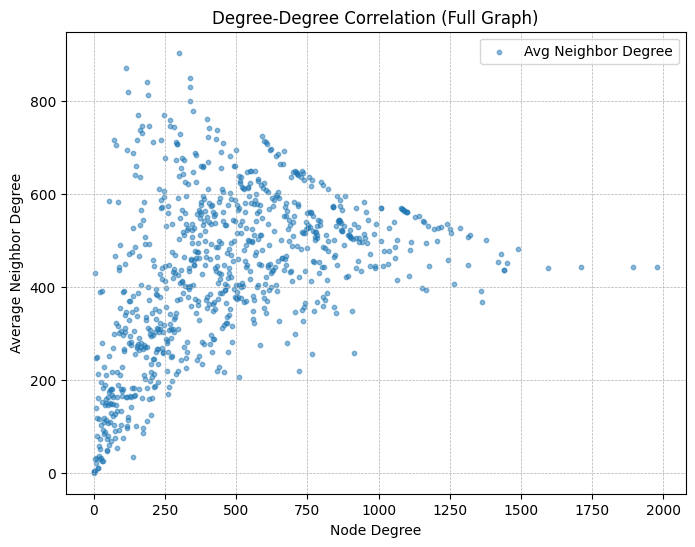

In [63]:
plot_degree_correlation(G)

In [6]:
communities, modularity, partition = networkx_louvain(G)
print(f"Number of communities: {len(communities)}")
print(f"Modularity: {modularity:.4f}")

Number of communities: 170702
Modularity: 0.7268


In [6]:

%%time
bc_results = nx.betweenness_centrality(G, k=500)

CPU times: user 4min 7s, sys: 228 ms, total: 4min 8s
Wall time: 4min 8s


In [7]:
%%time
eigenvector_results = nx.eigenvector_centrality(G, max_iter=100, tol=1e-4)

CPU times: user 3.28 s, sys: 20.1 ms, total: 3.3 s
Wall time: 3.3 s


In [8]:
%%time
katz_results = nx.katz_centrality(G, alpha=0.001, beta=1.0, max_iter=100, tol=1e-4)

CPU times: user 22.2 s, sys: 85 µs, total: 22.2 s
Wall time: 22.2 s


In [9]:
%%time
hubs, authorities = nx.hits(G, max_iter=100, tol=1e-4)

CPU times: user 5.2 s, sys: 3.88 s, total: 9.08 s
Wall time: 4.55 s


In [10]:
def get_top_nodes(centrality_dict, top_n=5):
    """Returns the top N nodes with the highest centrality scores."""
    return sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]

In [12]:
top_eigenvector = get_top_nodes(eigenvector_results, 5)
top_katz = get_top_nodes(katz_results, 5)
top_betweenness = get_top_nodes(bc_results, 5)
top_hubs = get_top_nodes(hubs, 5)
top_authorities = get_top_nodes(authorities, 5)

In [14]:
print("Top 5 Eigenvector Centrality Nodes:", top_eigenvector)
print("Top 5 Katz Centrality Nodes:", top_katz)
print("Top 5 Betweenness Centrality Nodes:", top_betweenness)
print("Top 5 HITS Hubs:", top_hubs)
print("Top 5 HITS Authorities:", top_authorities)

Top 5 Eigenvector Centrality Nodes: [('fannie farmer sugar cookies', 0.06713567429603894), ('favorite shortcake', 0.06713567429603894), ('girl scout cookie from 1917', 0.06713567429603894), ('grandma chin s sponge cake', 0.06713567429603894), ('mom wood s hot milk sponge cake', 0.06713567429603894)]
Top 5 Katz Centrality Nodes: [('fannie farmer sugar cookies', 0.009745528804707011), ('favorite shortcake', 0.009745528804707011), ('girl scout cookie from 1917', 0.009745528804707011), ('grandma chin s sponge cake', 0.009745528804707011), ('mom wood s hot milk sponge cake', 0.009745528804707011)]
Top 5 Betweenness Centrality Nodes: [('oven baked chips   potato wedges', 0.0013515234873399814), ('basted eggs', 0.0011918058615793688), ('potato and sausage in gravy', 0.0009275885701918316), ('spicy potato soup', 0.0009239930934906008), ('skillet spanish rice', 0.0009003716489172314)]
Top 5 HITS Hubs: [('basic muffins', 0.001423241465128268), ('cake formula', 0.001423241465128268), ('easy oven 

In [14]:
def plot_distribution(data, title):
    """Plots the distribution of centrality scores with a log-scaled y-axis."""
    values = list(data.values())
    plt.figure(figsize=(8, 5))
    sns.histplot(values, bins=50, kde=False)
    plt.yscale('log')  # Corrected this line
    plt.title(f"Distribution of {title}")
    plt.xlabel("Centrality Score")
    plt.ylabel("Frequency (Log Scale)")
    plt.show()

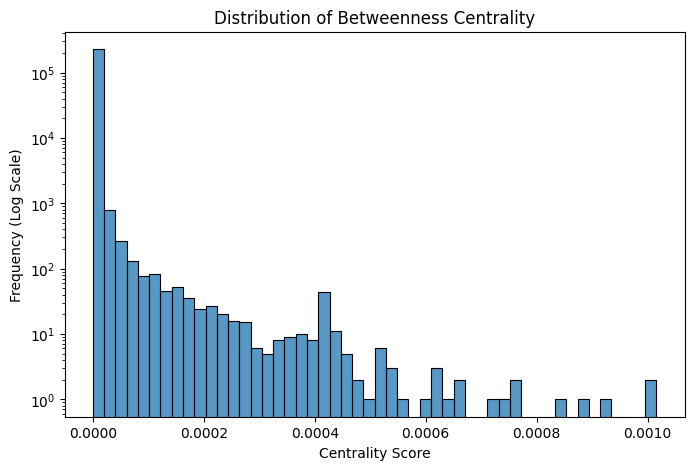

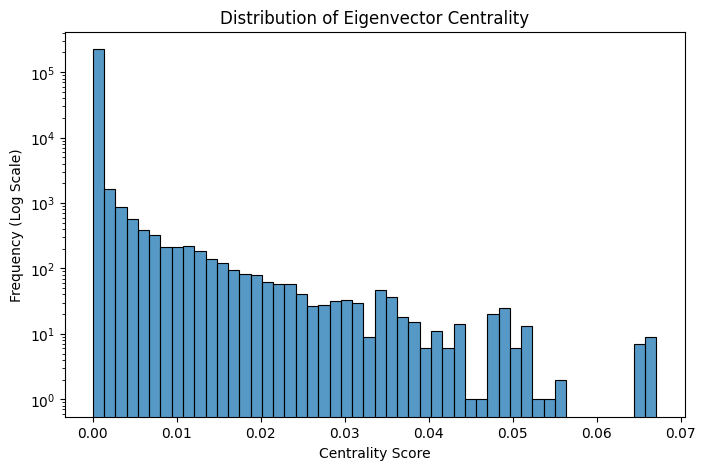

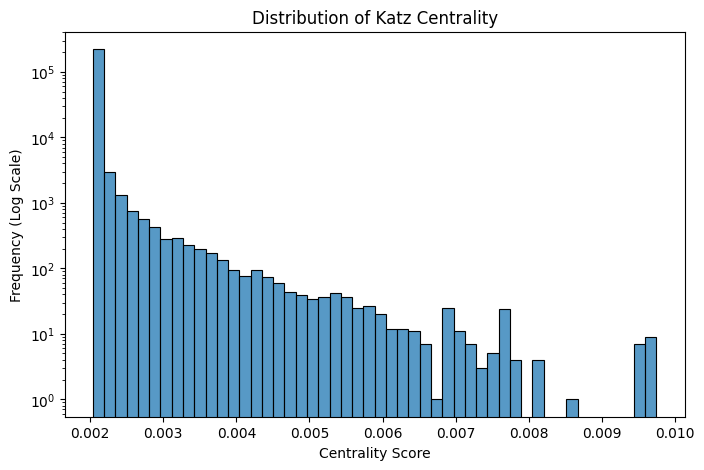

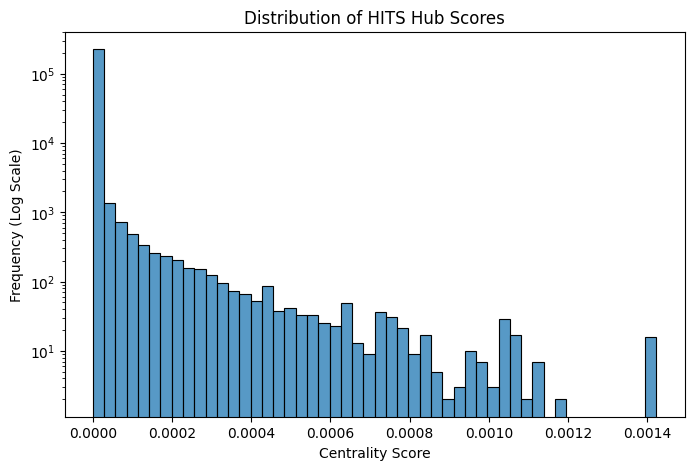

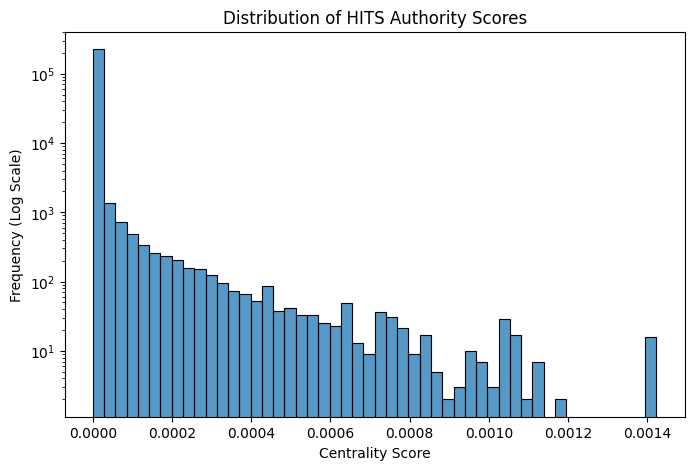

In [15]:
plot_distribution(bc_results, "Betweenness Centrality")
plot_distribution(eigenvector_results, "Eigenvector Centrality")
plot_distribution(katz_results, "Katz Centrality")
plot_distribution(hubs, "HITS Hub Scores")
plot_distribution(authorities, "HITS Authority Scores")

In [17]:
global_clustering = nx.transitivity(G)
print(f"Global Clustering Coefficient: {global_clustering}")

Global Clustering Coefficient: 0.3032679974464994


In [18]:
# Compute Local Clustering Coefficients
local_clustering = nx.clustering(G)


Local Clustering Coefficient: {'arriba   baked winter squash mexican style': 0, 'a bit different  breakfast pizza': 0, 'all in the kitchen  chili': 0, 'alouette  potatoes': 0, 'amish  tomato ketchup  for canning': 0, 'apple a day  milk shake': 0, 'aww  marinated olives': 0, 'backyard style  barbecued ribs': 0, 'bananas 4 ice cream  pie': 0, 'beat this  banana bread': 0, 'berry  good sandwich spread': 0, 'better than sex  strawberries': 0, 'better then bush s  baked beans': 0, 'boat house  collard greens': 0, 'calm your nerves  tonic': 0, 'chicken lickin  good  pork chops': 0, 'chile rellenos': 0, 'chinese  candy': 1.0, 'chinese  chop suey': 0, 'cream  of cauliflower soup  vegan': 0, 'cream  of spinach soup': 0, 'cream  of spinach soup  vegan': 0, 'crispy crunchy  chicken': 0, 'deep fried dessert thingys': 0.2463768115942029, 'easiest ever  hollandaise sauce': 0, 'emotional balance  spice mixture': 0, 'fool the meat eaters  chili': 0, 'forgotten  minestrone': 0, 'fried  potatoes': 0, 'g

In [22]:
for i, (node, coeff) in enumerate(local_clustering.items()):
    if i >= 10:
        break
    print(f"{node}: {coeff:.4f}")

arriba   baked winter squash mexican style: 0.0000
a bit different  breakfast pizza: 0.0000
all in the kitchen  chili: 0.0000
alouette  potatoes: 0.0000
amish  tomato ketchup  for canning: 0.0000
apple a day  milk shake: 0.0000
aww  marinated olives: 0.0000
backyard style  barbecued ribs: 0.0000
bananas 4 ice cream  pie: 0.0000
beat this  banana bread: 0.0000


In [23]:
# Select Top 10 Nodes by Degree for Local Clustering
top_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
top_local_clustering = {node: local_clustering[node] for node, _ in top_nodes}

In [24]:
# Print Local Clustering for Top Nodes
print("Top 10 Nodes by Degree and Their Local Clustering Coefficients:")
for node, coeff in top_local_clustering.items():
    print(f"{node}: {coeff}")


Top 10 Nodes by Degree and Their Local Clustering Coefficients:
fannie farmer sugar cookies: 0.15006686203076267
favorite shortcake: 0.15006686203076267
girl scout cookie from 1917: 0.15006686203076267
grandma chin s sponge cake: 0.15006686203076267
mom wood s hot milk sponge cake: 0.15006686203076267
original girl scout cookies: 0.15006686203076267
puffy sugar cookies: 0.15006686203076267
quick waffles: 0.15006686203076267
white cake: 0.15006686203076267
basic muffins: 0.1608202318631117


In [25]:
# Create a Random Graph for Comparison (same number of nodes & similar density)
random_graph = nx.erdos_renyi_graph(n=G.number_of_nodes(), p=nx.density(G))

In [26]:
# Compute Global Clustering Coefficient for Random Graph
random_global_clustering = nx.transitivity(random_graph)
print(f"Random Graph Clustering Coefficient: {random_global_clustering}")

Random Graph Clustering Coefficient: 5.094652809479518e-05


In [27]:
# Compare Results
print("\nComparison:")
print(f"Original Network Clustering: {global_clustering}")
print(f"Random Graph Clustering: {random_global_clustering}")


Comparison:
Original Network Clustering: 0.3032679974464994
Random Graph Clustering: 5.094652809479518e-05


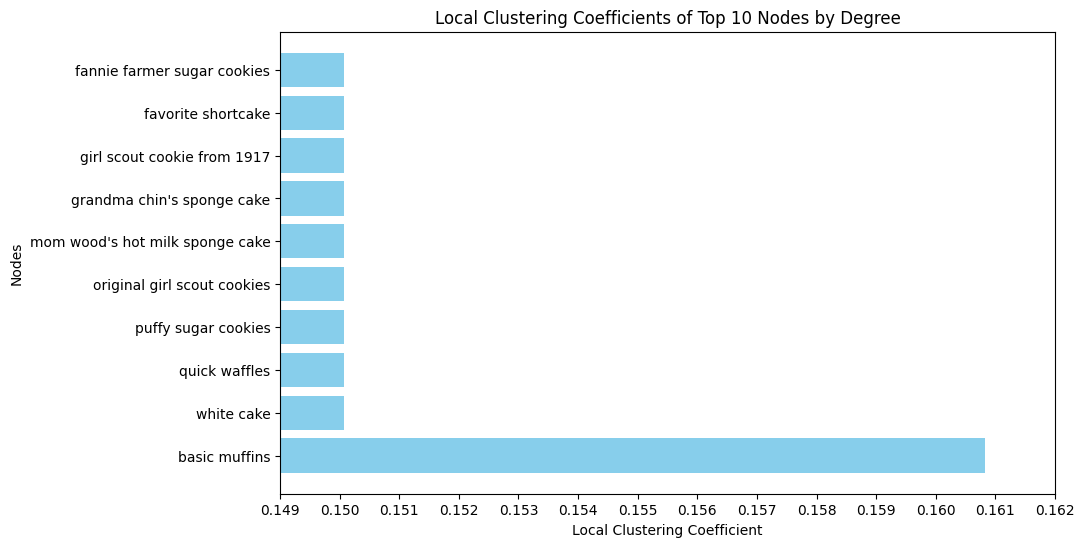

In [29]:
# Data
nodes = [
    "fannie farmer sugar cookies", "favorite shortcake", "girl scout cookie from 1917", 
    "grandma chin's sponge cake", "mom wood's hot milk sponge cake", "original girl scout cookies", 
    "puffy sugar cookies", "quick waffles", "white cake", "basic muffins"
]
clustering_coeffs = [
    0.15007, 0.15007, 0.15007, 0.15007, 0.15007, 0.15007, 
    0.15007, 0.15007, 0.15007, 0.16082
]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(nodes, clustering_coeffs, color='skyblue')
plt.xlabel("Local Clustering Coefficient")
plt.ylabel("Nodes")
plt.title("Local Clustering Coefficients of Top 10 Nodes by Degree")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top

# Adjust x-axis scale for better visibility
plt.xlim(0.149, 0.162)  # Set x-axis limits to focus on the range of values
plt.xticks([0.149, 0.150, 0.151, 0.152, 0.153, 0.154, 0.155, 0.156, 0.157, 0.158, 0.159, 0.160, 0.161, 0.162])

# Show plot
plt.show()
